# 1

### Duomenų nuskaitymas vyksta per atskirą klasę. Į šį objektą nurdoma vietovės kodas, API URL. Ši klasė turi turėti du metodus:
### a) Istorinių duomenų nuskaitymas už nurodytą laiko intervalą nuo - iki;
### b) Prognozės duomenų nuskaitymas;
### Abiem atvejais duomenys turėtų būti gražinami pandas.DataFrame  formatu, kur indeksas yra laikas (pd.DatetimeIndex) su įvertinta laiko zona;

### The data is read via separate class. This object contains the location code, the API URL. This class must have two methods:
### a) Historical data retrieval for a specified time interval from - to;
### b) Forecast data scanning;
### In both cases, the data should be returned by pandas.DataFrame format, where the index is the time (pd.DatetimeIndex) with the estimated time zone;

In [19]:
import requests
import pandas as pd
import time
from datetime import datetime, timedelta

In [20]:
class Data:
    """
    A class for retrieving and managing weather observation and forecast data from an API.

    This class provides methods to fetch both historical weather observations and 
    forecast data from a specified weather station through a RESTful API. It handles 
    data retrieval, time zone conversions, and basic error handling.

    Attributes:
        station_code (str): The unique identifier for the weather station.
        api_url (str): The base URL for the weather data API.

    Example:
        >>> data_client = Data('STATION123', 'https://api.weather-service.com')
        >>> historical_data = data_client.historical_data_retrieval('2024-01-01', '2024-01-07')
        >>> forecast_data = data_client.forecast_data_retrieval()
    """
    
    def __init__(self, station_code, api_url):
        """
        Initialize the Data object with station code and API URL.

        Args:
            station_code (str): The unique identifier for the weather station.
            api_url (str): The base URL for the weather data API.
        """
        self.station_code = station_code
        self.api_url = api_url

    def historical_data_retrieval(self, start_date, end_date):
        """
        Retrieve historical weather observations for a specified date range.

        This method fetches daily weather observations between the start and end dates.
        It includes rate limiting and handles timezone conversions. Data is retrieved
        day by day to manage API load and handle potential errors gracefully.

        Args:
            start_date (str): Start date in 'YYYY-MM-DD' format.
            end_date (str): End date in 'YYYY-MM-DD' format.

        Returns:
            pandas.DataFrame: A DataFrame containing the historical weather observations.
                            The DataFrame is indexed by timestamp in the local timezone.
                            Returns an empty DataFrame if no data is available.

        Raises:
            requests.exceptions.RequestException: If there's an error in the API request.
                                                The error details are logged but redacted.
        """
        result = pd.DataFrame()
        dt_range = pd.date_range(start=start_date, end=end_date, freq='D')
        
        for date in dt_range:
            formatted_date = date.strftime('%Y-%m-%d')
            HOST = self.api_url + "/stations/{}/observations/{}".format(self.station_code, formatted_date)
            try:
                r = requests.get(HOST)
                r.raise_for_status()  # Check for HTTP errors
                temp = pd.DataFrame.from_dict(r.json()['observations'])
                temp['observationTimeUtc'] = pd.to_datetime(temp['observationTimeUtc'])
                temp.set_index('observationTimeUtc', inplace=True)
                temp.index = temp.index.tz_localize('UTC').tz_convert('EET')  # Convert from UTC to EET
                result = pd.concat([result, temp], axis=0)
                time.sleep(0.34)
            except requests.exceptions.RequestException as e:
                print(f"Error retrieving data for {formatted_date}: {e}")
                continue

        return result

    def forecast_data_retrieval(self):
        """
        Retrieve weather forecast data for the station.

        This method fetches the latest available forecast data from the API.
        It handles timezone conversions and basic error handling.

        Returns:
            pandas.DataFrame: A DataFrame containing the forecast data.
                            The DataFrame is indexed by timestamp in the local timezone.
                            Returns an empty DataFrame if the request fails.

        Raises:
            requests.exceptions.RequestException: If there's an error in the API request.
                                                The error details are logged but redacted.
        """
        HOST = self.api_url + "/places/{}/forecasts/long-term".format(self.station_code)
        try:
            r = requests.get(HOST)
            r.raise_for_status()  # Check for HTTP errors
            df = pd.DataFrame.from_dict(r.json()['forecastTimestamps'])
            df['forecastTimeUtc'] = pd.to_datetime(df['forecastTimeUtc'])
            df.set_index('forecastTimeUtc', inplace=True)
            df.index = df.index.tz_localize('UTC').tz_convert('EET')  # Convert from UTC to EET
            return df
        except requests.exceptions.RequestException as e:
            print(f"Error retrieving forecast data: {e}")
            return pd.DataFrame()  # Return empty DataFrame on error

# 2

#### Nuskaičius istorinius duomenis už praeitus metus (laikotarpis nuo šiandien iki metai atgal) suskaičiuoti ir atvaizduoti šiuos rodiklius:
#### a) Vidutinė metų temperatūra, oro drėgmė;
#### b) Vidutinė metų dienos, ir nakties temperatūra priimant kad skaičiuojama LT laiko zonoje ir diena yra tarp 08:00 ir 20:00;
#### c) Kiek savaitgalių (šeštadienis/sekmadienis - 1 savaitgalis) per šį laikotarpį buvo prognozuojama kad lis;

### After scanning the historical data for the past year (from today to a year ago), calculate and display the following indicators:
### a) Average annual temperature, humidity;
### b) Average annual day and night temperatures, assuming that the calculation is made in the LT time zone and the day is between 08:00 and 20:00;
### c) How many weekends (Saturday/Sunday - 1 weekend) during this period it was forecast to rain;

In [21]:
# Constants and setup
today = datetime.now()
date1 = (today - timedelta(days=365)).strftime('%Y-%m-%d')
date2 = today.strftime('%Y-%m-%d')
station_code1 = 'vilniaus-ams'
api = 'https://api.meteo.lt/v1'
historical_data1 = Data(station_code=station_code1, api_url=api)

In [22]:
# Retrieve historical data
historical_df = historical_data1.historical_data_retrieval(start_date=date1, end_date=date2)

C:\Users\ggriu\AppData\Local\Temp\ipykernel_15176\1681256932.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result, temp], axis=0)
C:\Users\ggriu\AppData\Local\Temp\ipykernel_15176\1681256932.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result, temp], axis=0)


## a)

In [23]:
# Calculate and print annual average air temperature
historical_df['airTemperature'].mean()

9.448113423279215

In [24]:
# Calculate and print annual average air humidity
historical_df['relativeHumidity'].mean()

78.3286073633661

## b)

In [25]:
# Annual average daytime temperature
daytime = historical_df.between_time('06:00', '18:00')
daytime['airTemperature'].mean()

10.254006748207507

In [26]:
# Annual average nighttime temperature
nighttime = historical_df.between_time('18:00', '06:00')
nighttime['airTemperature'].mean()

8.608129222972973

## c)

In [27]:
# Number of rainy weekends calculation
weekends = historical_df[historical_df.index.dayofweek >= 5]
rainy_weekends = weekends[weekends['conditionCode'].isin(['rain-showers','light-rain-at-times','light-rain','rain','heavy-rain'])]
unique_rainy_weekends = rainy_weekends.index.to_period('W').nunique()
unique_rainy_weekends

C:\Users\ggriu\AppData\Local\Temp\ipykernel_15176\4030070502.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  unique_rainy_weekends = rainy_weekends.index.to_period('W').nunique()


33

# 3

#### Nuskaičius prognozės duomenis juos apjungti su istoriniais. Atvaizduoti grafiką, kuris rodo paskutinės savaitės išmatuotą temperatūrą ir ateinančio periodo prognozuojama temperatūrą.

### Combine the forecast data with the historical data. Plot a graph showing the measured temperature for the last week and the forecast temperature for the next period.

In [28]:
import matplotlib.pyplot as plt

In [29]:
# Constants and setup
last_week = today - timedelta(days=7)
historical_last_week = historical_data1.historical_data_retrieval(start_date=last_week.strftime('%Y-%m-%d'), end_date=today.strftime('%Y-%m-%d'))

In [30]:
station_code2 = 'vilnius'
forecast_data = Data(station_code=station_code2, api_url=api)

In [31]:
# Retrieve forecast data
forecast_df = forecast_data.forecast_data_retrieval()

In [32]:
# Combine data for visualization
combined_data = pd.concat([historical_last_week['airTemperature'], forecast_df['airTemperature']])

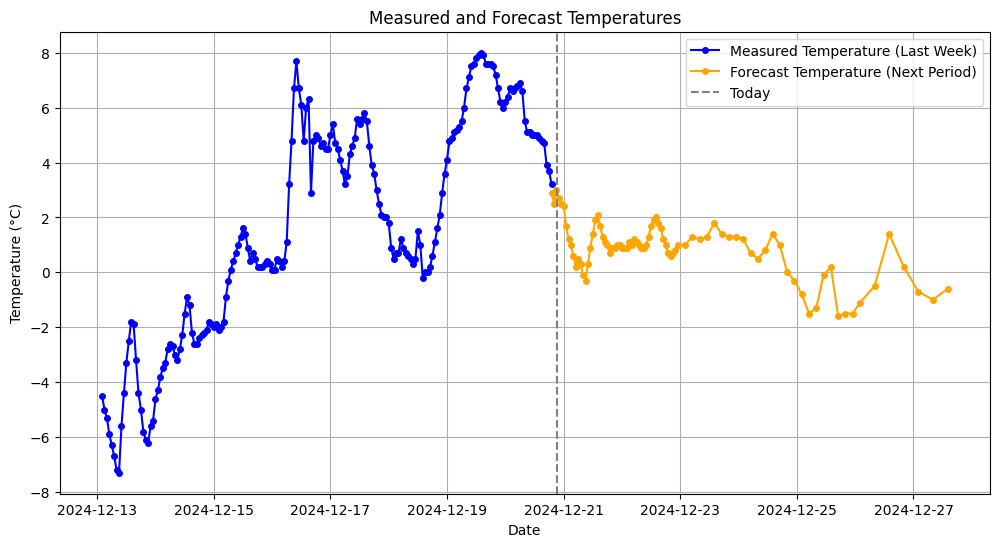

In [33]:
# Visualization of temperatures
plt.figure(figsize=(12, 6))
plt.plot(
    historical_last_week.index, 
    historical_last_week['airTemperature'], 
    label='Measured Temperature (Last Week)', 
    color='blue',
    marker='o',
    markersize=4
)
plt.plot(
    forecast_df.index, 
    forecast_df['airTemperature'], 
    label='Forecast Temperature (Next Period)', 
    color='orange',
    marker='o',
    markersize=4
)
plt.axvline(today, color='gray', linestyle='--', label='Today')  # Mark the current time
plt.title("Measured and Forecast Temperatures")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid()
plt.show()

# 4

#### Visi nuskaityti duomenys yra valandiniai. Parašyti funkciją, į kurią padavus temperatūros pandas. Series suskaičiuotų tarpines reikšmes ir pagražintų rezultatą pandas. Series kurio dažnis yra 5 minutės. Tarpines reikšmes interpoliuoti.

### All readings are hourly. Write a function to which the temperature pandas are fed. Series will calculate the intermediate values and beautify the result in pandas. Series with a frequency of 5 minutes. Interpolate the intermediate values.

In [34]:
# Interpolation function
def interpolate_data(dataframe):
    """
    Interpolates intermediate temperature values for a pandas Series with hourly readings
    to a frequency of 5 minutes.

    Parameters:
        temp_series (pd.Series): A pandas Series with a DatetimeIndex and hourly frequency.

    Returns:
        pd.Series: A pandas Series with 5-minute frequency and interpolated values.
    """
    # Ensure the index is a DatetimeIndex and sort it
    dataframe = dataframe.sort_index()

    # Create a new index with 5-minute frequency
    new_index = pd.date_range(start=dataframe.index.min(), 
                              end=dataframe.index.max(), 
                              freq='5T')

    # Reindex the original Series to the new index
    dataframe_5min = dataframe.reindex(new_index)

    # Interpolate to fill the intermediate values
    dataframe_5min = dataframe_5min.interpolate(method='linear')

    return dataframe_5min

In [35]:
# Interpolate forecast data
interpolated_forecast = interpolate_data(forecast_df)

C:\Users\ggriu\AppData\Local\Temp\ipykernel_15176\2585756707.py:25: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  dataframe_5min = dataframe_5min.interpolate(method='linear')


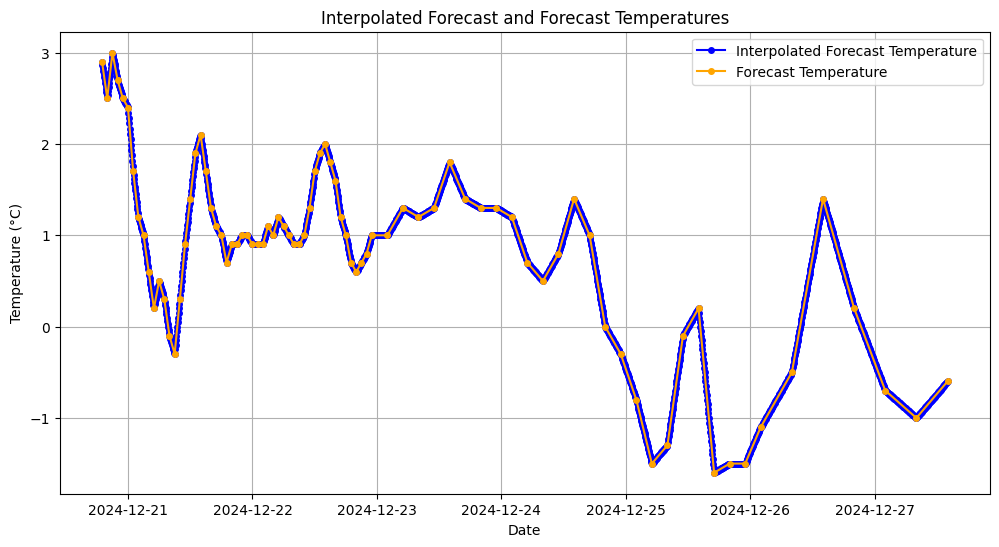

In [36]:
# Visualization of interpolated forecast temperatures
plt.figure(figsize=(12, 6))
plt.plot(
    interpolated_forecast.index, 
    interpolated_forecast['airTemperature'], 
    label='Interpolated Forecast Temperature', 
    color='blue',
    marker='o',
    markersize=4
)
plt.plot(
    forecast_df.index, 
    forecast_df['airTemperature'], 
    label='Forecast Temperature', 
    color='orange',
    marker='o',
    markersize=4
)
plt.title("Interpolated Forecast and Forecast Temperatures")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid()
plt.show()